In [1]:
!pip install geopandas

In [2]:
pip install matplotlib-scalebar

In [3]:
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import collections
import torch
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from scipy.cluster.vq import kmeans2, whiten
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
####################################################################################
#################load files, you may change it to your own direction##############
####################################################################################

drivepath = "/content/drive/MyDrive/Colab/Dan/Chapter1/2023LIME_escooter/escooter2023_trajectory_hourly_count.shp"
LS = gpd.read_file(drivepath)

drivepath = "/content/drive/MyDrive/Colab/Dan/Chapter1/2023LIME_bike/limebike2023_trajectory_hourly_count.shp"
LB = gpd.read_file(drivepath)

drivepath = "/content/drive/MyDrive/Colab/Dan/Capitalbike files/capitalbike2023_trajectory_hourly_count.geojson"
CB = gpd.read_file(drivepath)

drivepath = "/content/drive/MyDrive/Colab/Dan/Chapter1/2023Allyear_strava/strava2023_trajectory_hourly_count.shp"
ST = gpd.read_file(drivepath)

<ipython-input-16-a55daad7f38d>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LS.drop(columns='geometry', inplace=True)
<ipython-input-16-a55daad7f38d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LB.drop(columns='geometry', inplace=True)
<ipython-input-16-a55daad7f38d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CB.drop(columns='geometry', inplace=True)
<ipython-input-16-a55daad7f38d>:24: SettingWithCopyWarning: 
A valu

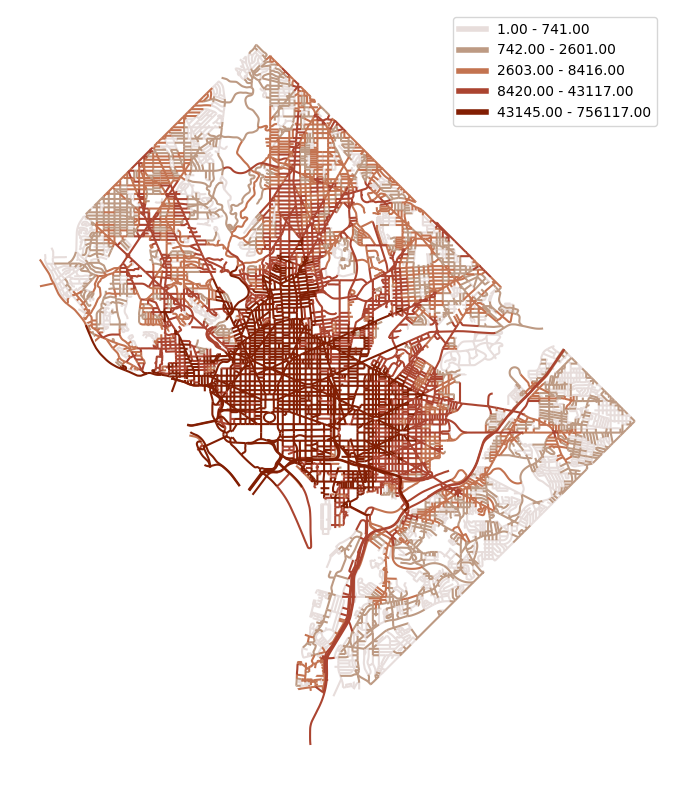

Category 0: Count = 2742, Value Range = [1.00, 741.00]
Category 1: Count = 2738, Value Range = [742.00, 2601.00]
Category 2: Count = 2742, Value Range = [2603.00, 8416.00]
Category 3: Count = 2738, Value Range = [8420.00, 43117.00]
Category 4: Count = 2740, Value Range = [43145.00, 756117.00]


In [16]:
####################################################################################
#################  processing data for Figure 2(a)  ################################
####################################################################################

columns_to_convert = [
    'All_D_1', 'All_D_2', 'All_D_3', 'All_D_4', 'All_D_5', 'All_D_6', 'All_D_7', 'All_D_8', 'All_D_9',
    'All_D_10', 'All_D_11', 'All_D_12', 'All_D_13', 'All_D_14', 'All_D_15', 'All_D_16', 'All_D_17', 'All_D_18', 'All_D_19',
    'All_D_20', 'All_D_21', 'All_D_22', 'All_D_23', 'All_D_0', 'All_Y_1', 'All_Y_2', 'All_Y_3', 'All_Y_4', 'All_Y_5',
    'All_Y_6', 'All_Y_7', 'All_Y_8', 'All_Y_9', 'All_Y_10', 'All_Y_11', 'All_Y_12', 'All_Y_13', 'All_Y_14', 'All_Y_15',
    'All_Y_16', 'All_Y_17', 'All_Y_18', 'All_Y_19', 'All_Y_20', 'All_Y_21', 'All_Y_22', 'All_Y_23', 'All_Y_0'
]

def process_gdf(gdf, new_column_name):
    for col in columns_to_convert:
        gdf[col] = pd.to_numeric(gdf[col], errors='coerce')
    gdf[new_column_name] = gdf[columns_to_convert].sum(axis=1)
    return gdf[[new_column_name, 'geometry']]

LS = process_gdf(LS, 'escooter_2023')
LB = process_gdf(LB, 'limebike_2023')
CB = process_gdf(CB, 'capitalbike_2023')
ST = process_gdf(ST, 'strava_2023')

geometry = LS[['geometry']].copy()
LS.drop(columns='geometry', inplace=True)
LB.drop(columns='geometry', inplace=True)
CB.drop(columns='geometry', inplace=True)
ST.drop(columns='geometry', inplace=True)

gdf_all = pd.concat([LS, LB, CB, ST, geometry], axis=1)
gdf_all = gpd.GeoDataFrame(gdf_all, geometry='geometry')
gdf_all.reset_index(drop=True, inplace=True)
gdf_all = gdf_all.drop(index=5242)

# sum every column
total_escooter = gdf_all['escooter_2023'].sum()
total_limebike = gdf_all['limebike_2023'].sum()
total_capitalbike = gdf_all['capitalbike_2023'].sum()
total_strava = gdf_all['strava_2023'].sum()

# get ratio
gdf_all['escooter_2023P'] = gdf_all['escooter_2023'] / total_escooter
gdf_all['limebike_2023P'] = gdf_all['limebike_2023'] / total_limebike
gdf_all['capitalbike_2023P'] = gdf_all['capitalbike_2023'] / total_capitalbike
gdf_all['strava_2023P'] = gdf_all['strava_2023'] / total_strava


# rename
gdf_all.rename(columns={
    'escooter_2023': 'esc_2023',
    'limebike_2023': 'lim_2023',
    'capitalbike_2023': 'cap_2023',
    'strava_2023': 'str_2023',
    'escooter_2023P': 'esc_P',
    'limebike_2023P': 'lim_P',
    'capitalbike_2023P': 'cap_P',
    'strava_2023P': 'str_P'
}, inplace=True)

drivepath = "Allmodes_total_count.shp"
gdf_all.to_file(drivepath, driver='ESRI Shapefile')

gdf=gdf_all

gdf['sum_2023'] = gdf[['esc_2023', 'lim_2023', 'cap_2023', 'str_2023']].sum(axis=1)

zero_rows = gdf[gdf['sum_2023'] == 0]
gdf = gdf[gdf['sum_2023'] != 0].copy()
gdf['centroid'] = gdf['geometry'].centroid

gdf['centroid_y'] = gdf['centroid'].apply(lambda point: point.y)


gdf = gdf[gdf['centroid_y'] > 128000]

# Compute quantile breaks
quantiles = gdf['sum_2023'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values

# Assign categories based on the quantiles
gdf['sum_2023_category'] = pd.cut(gdf['sum_2023'], bins=quantiles, labels=False, include_lowest=True)

# Define the colors for each category
colors = {
    0: '#e7dddb',
    1: '#bd9a83',
    2: '#c37350',
    3: '#ab4430',
    4: '#821e03'
}

# Compute the value range for each category
category_stats = []
for category in range(5):
    count = gdf[gdf['sum_2023_category'] == category].shape[0]
    min_value = gdf[gdf['sum_2023_category'] == category]['sum_2023'].min()
    max_value = gdf[gdf['sum_2023_category'] == category]['sum_2023'].max()
    category_stats.append((category, count, min_value, max_value))

# Plot the GeoDataFrame with colors
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for category, color in colors.items():
    category_data = gdf[gdf['sum_2023_category'] == category]
    category_label = f'{category_stats[category][2]:.2f} - {category_stats[category][3]:.2f}'
    category_data.plot(ax=ax, color=color, label=category_label)

# Remove coordinate borders
ax.axis('off')

legend_elements = [Line2D([0], [0], color=color, lw=4, label=f'{category_stats[cat][2]:.2f} - {category_stats[cat][3]:.2f}') for cat, color in colors.items()]
ax.legend(handles=legend_elements)
# plt.title('Geometry colored by sum_2023 categories using Quantiles')
plt.show()

# Print the category statistics
for category, count, min_value, max_value in category_stats:
    print(f"Category {category}: Count = {count}, Value Range = [{min_value:.2f}, {max_value:.2f}]")

In [ ]:
####################################################################################
#################reload files, you may change it to your own direction##############
####################################################################################

drivepath = "/content/drive/MyDrive/Colab/Dan/Chapter1/2023LIME_escooter/escooter2023_trajectory_hourly_count.shp"
LS = gpd.read_file(drivepath)

drivepath = "/content/drive/MyDrive/Colab/Dan/Chapter1/2023LIME_bike/limebike2023_trajectory_hourly_count.shp"
LB = gpd.read_file(drivepath)

drivepath = "/content/drive/MyDrive/Colab/Dan/Capitalbike files/capitalbike2023_trajectory_hourly_count.geojson"
CB = gpd.read_file(drivepath)

drivepath = "/content/drive/MyDrive/Colab/Dan/Chapter1/2023Allyear_strava/strava2023_trajectory_hourly_count.shp"
ST = gpd.read_file(drivepath)

In [7]:
####################################################################################
################# Merge 4 files together ###########################################
####################################################################################

LS = LS.rename(columns={col: f'LS_{col}' for col in LS.columns if col != 'geometry'})

LB = LB.rename(columns={col: f'LB_{col}' for col in LB.columns if col != 'geometry'})

CB = CB.rename(columns={col: f'CB_{col}' for col in CB.columns if col != 'geometry'})

ST = ST.rename(columns={col: f'ST_{col}' for col in ST.columns if col != 'geometry'})

geometry = LS['geometry']

LS = LS.drop(columns=['geometry'])
LB = LB.drop(columns=['geometry'])
CB = CB.drop(columns=['geometry'])
ST = ST.drop(columns=['geometry'])

merged_df = pd.concat([LS, LB, CB, ST], axis=1)
merged_gdf = gpd.GeoDataFrame(merged_df, geometry=geometry)

merged_gdf.to_file("four_modes.geojson", driver='GeoJSON')

gdf=merged_gdf


gdf['LS_D1'] = gdf[['LS_All_D_6', 'LS_All_D_7', 'LS_All_D_8', 'LS_All_D_9', 'LS_All_D_10']].sum(axis=1)
gdf['LS_D2'] = gdf[['LS_All_D_11', 'LS_All_D_12', 'LS_All_D_13', 'LS_All_D_14', 'LS_All_D_15']].sum(axis=1)
gdf['LS_D3'] = gdf[['LS_All_D_16', 'LS_All_D_17', 'LS_All_D_18', 'LS_All_D_19', 'LS_All_D_20']].sum(axis=1)
gdf['LS_D4'] = gdf[['LS_All_D_21', 'LS_All_D_22', 'LS_All_D_23', 'LS_All_D_0', 'LS_All_D_1']].sum(axis=1)

gdf['LS_Y1'] = gdf[['LS_All_Y_6', 'LS_All_Y_7', 'LS_All_Y_8', 'LS_All_Y_9', 'LS_All_Y_10']].sum(axis=1)
gdf['LS_Y2'] = gdf[['LS_All_Y_11', 'LS_All_Y_12', 'LS_All_Y_13', 'LS_All_Y_14', 'LS_All_Y_15']].sum(axis=1)
gdf['LS_Y3'] = gdf[['LS_All_Y_16', 'LS_All_Y_17', 'LS_All_Y_18', 'LS_All_Y_19', 'LS_All_Y_20']].sum(axis=1)
gdf['LS_Y4'] = gdf[['LS_All_Y_21', 'LS_All_Y_22', 'LS_All_Y_23', 'LS_All_Y_0', 'LS_All_Y_1']].sum(axis=1)

gdf['LB_D1'] = gdf[['LB_All_D_6', 'LB_All_D_7', 'LB_All_D_8', 'LB_All_D_9', 'LB_All_D_10']].sum(axis=1)
gdf['LB_D2'] = gdf[['LB_All_D_11', 'LB_All_D_12', 'LB_All_D_13', 'LB_All_D_14', 'LB_All_D_15']].sum(axis=1)
gdf['LB_D3'] = gdf[['LB_All_D_16', 'LB_All_D_17', 'LB_All_D_18', 'LB_All_D_19', 'LB_All_D_20']].sum(axis=1)
gdf['LB_D4'] = gdf[['LB_All_D_21', 'LB_All_D_22', 'LB_All_D_23', 'LB_All_D_0', 'LB_All_D_1']].sum(axis=1)

gdf['LB_Y1'] = gdf[['LB_All_Y_6', 'LB_All_Y_7', 'LB_All_Y_8', 'LB_All_Y_9', 'LB_All_Y_10']].sum(axis=1)
gdf['LB_Y2'] = gdf[['LB_All_Y_11', 'LB_All_Y_12', 'LB_All_Y_13', 'LB_All_Y_14', 'LB_All_Y_15']].sum(axis=1)
gdf['LB_Y3'] = gdf[['LB_All_Y_16', 'LB_All_Y_17', 'LB_All_Y_18', 'LB_All_Y_19', 'LB_All_Y_20']].sum(axis=1)
gdf['LB_Y4'] = gdf[['LB_All_Y_21', 'LB_All_Y_22', 'LB_All_Y_23', 'LB_All_Y_0', 'LB_All_Y_1']].sum(axis=1)

gdf['CB_D1'] = gdf[['CB_All_D_6', 'CB_All_D_7', 'CB_All_D_8', 'CB_All_D_9', 'CB_All_D_10']].sum(axis=1)
gdf['CB_D2'] = gdf[['CB_All_D_11', 'CB_All_D_12', 'CB_All_D_13', 'CB_All_D_14', 'CB_All_D_15']].sum(axis=1)
gdf['CB_D3'] = gdf[['CB_All_D_16', 'CB_All_D_17', 'CB_All_D_18', 'CB_All_D_19', 'CB_All_D_20']].sum(axis=1)
gdf['CB_D4'] = gdf[['CB_All_D_21', 'CB_All_D_22', 'CB_All_D_23', 'CB_All_D_0', 'CB_All_D_1']].sum(axis=1)

gdf['CB_Y1'] = gdf[['CB_All_Y_6', 'CB_All_Y_7', 'CB_All_Y_8', 'CB_All_Y_9', 'CB_All_Y_10']].sum(axis=1)
gdf['CB_Y2'] = gdf[['CB_All_Y_11', 'CB_All_Y_12', 'CB_All_Y_13', 'CB_All_Y_14', 'CB_All_Y_15']].sum(axis=1)
gdf['CB_Y3'] = gdf[['CB_All_Y_16', 'CB_All_Y_17', 'CB_All_Y_18', 'CB_All_Y_19', 'CB_All_Y_20']].sum(axis=1)
gdf['CB_Y4'] = gdf[['CB_All_Y_21', 'CB_All_Y_22', 'CB_All_Y_23', 'CB_All_Y_0', 'CB_All_Y_1']].sum(axis=1)


gdf['ST_D1'] = gdf[['ST_All_D_6', 'ST_All_D_7', 'ST_All_D_8', 'ST_All_D_9', 'ST_All_D_10']].sum(axis=1)
gdf['ST_D2'] = gdf[['ST_All_D_11', 'ST_All_D_12', 'ST_All_D_13', 'ST_All_D_14', 'ST_All_D_15']].sum(axis=1)
gdf['ST_D3'] = gdf[['ST_All_D_16', 'ST_All_D_17', 'ST_All_D_18', 'ST_All_D_19', 'ST_All_D_20']].sum(axis=1)
gdf['ST_D4'] = gdf[['ST_All_D_21', 'ST_All_D_22', 'ST_All_D_23', 'ST_All_D_0', 'ST_All_D_1']].sum(axis=1)

gdf['ST_Y1'] = gdf[['ST_All_Y_6', 'ST_All_Y_7', 'ST_All_Y_8', 'ST_All_Y_9', 'ST_All_Y_10']].sum(axis=1)
gdf['ST_Y2'] = gdf[['ST_All_Y_11', 'ST_All_Y_12', 'ST_All_Y_13', 'ST_All_Y_14', 'ST_All_Y_15']].sum(axis=1)
gdf['ST_Y3'] = gdf[['ST_All_Y_16', 'ST_All_Y_17', 'ST_All_Y_18', 'ST_All_Y_19', 'ST_All_Y_20']].sum(axis=1)
gdf['ST_Y4'] = gdf[['ST_All_Y_21', 'ST_All_Y_22', 'ST_All_Y_23', 'ST_All_Y_0', 'ST_All_Y_1']].sum(axis=1)



new_gdf = gdf[['LS_D1', 'LS_D2', 'LS_D3', 'LS_D4','LB_D1', 'LB_D2', 'LB_D3', 'LB_D4','ST_D1', 'ST_D2', 'ST_D3', 'ST_D4','CB_D1', 'CB_D2', 'CB_D3', 'CB_D4','LS_Y1', 'LS_Y2', 'LS_Y3', 'LS_Y4', 'LB_Y1', 'LB_Y2', 'LB_Y3', 'LB_Y4', 'ST_Y1', 'ST_Y2', 'ST_Y3', 'ST_Y4', 'CB_Y1', 'CB_Y2', 'CB_Y3', 'CB_Y4', 'geometry']]
new_drivepath = "four_modes_8period.geojson"
new_gdf.to_file(new_drivepath, driver='GeoJSON')

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


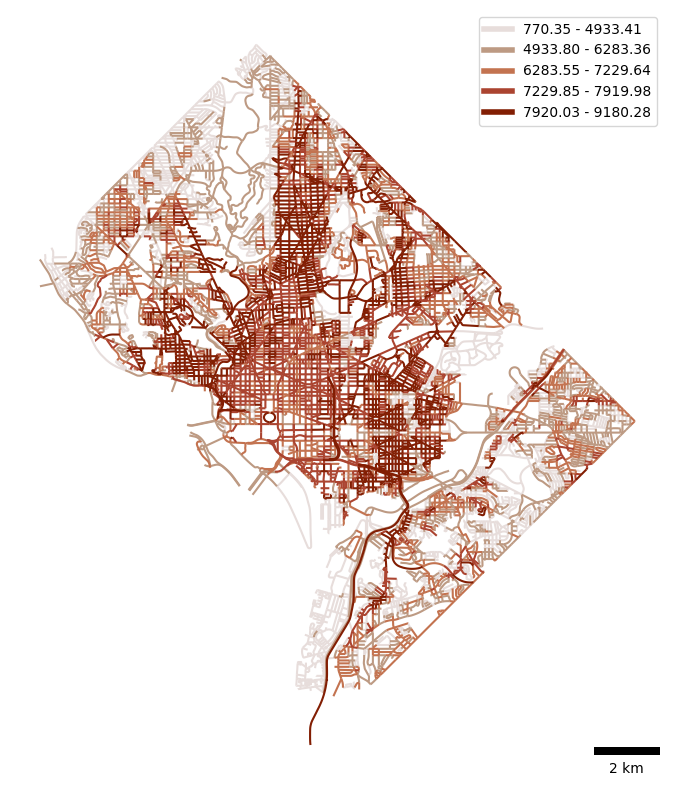

Category 0: Count = 2739, Value Range = [770.35, 4933.41]
Category 1: Count = 2738, Value Range = [4933.80, 6283.36]
Category 2: Count = 2739, Value Range = [6283.55, 7229.64]
Category 3: Count = 2738, Value Range = [7229.85, 7919.98]
Category 4: Count = 2739, Value Range = [7920.03, 9180.28]


In [8]:
####################################################################################
#################  processing data for Figure 2(b)  ################################
####################################################################################


gdf = new_gdf
columns = ['LS_D1', 'LS_D2', 'LS_D3', 'LS_D4',
           'LB_D1', 'LB_D2', 'LB_D3', 'LB_D4',
           'ST_D1', 'ST_D2', 'ST_D3', 'ST_D4',
           'CB_D1', 'CB_D2', 'CB_D3', 'CB_D4',
           'LS_Y1', 'LS_Y2', 'LS_Y3', 'LS_Y4',
           'LB_Y1', 'LB_Y2', 'LB_Y3', 'LB_Y4',
           'ST_Y1', 'ST_Y2', 'ST_Y3', 'ST_Y4',
           'CB_Y1', 'CB_Y2', 'CB_Y3', 'CB_Y4']

data = gdf[columns]

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

cosine_sim_matrix = cosine_similarity(normalized_data)

C_similarity = cosine_sim_matrix.sum(axis=1) - 1

gdf['C_similarity'] = C_similarity

normalized_df = pd.DataFrame(normalized_data, columns=columns)

negative_ones = gdf[gdf['C_similarity'] == -1]


gdf = gdf[gdf['C_similarity'] != -1].copy()

gdf['centroid'] = gdf['geometry'].centroid

gdf['centroid_y'] = gdf['centroid'].apply(lambda point: point.y)


gdf = gdf[gdf['centroid_y'] > 128000]

# Compute quantile breaks
quantiles = gdf['C_similarity'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values

# Assign categories based on the quantiles
gdf['C_similarity_category'] = pd.cut(gdf['C_similarity'], bins=quantiles, labels=False, include_lowest=True)

# Define the colors for each category
colors = {
    0: '#e7dddb',
    1: '#bd9a83',
    2: '#c37350',
    3: '#ab4430',
    4: '#821e03'
}

# Compute the value range for each category
category_stats = []
for category in range(5):
    count = gdf[gdf['C_similarity_category'] == category].shape[0]
    min_value = gdf[gdf['C_similarity_category'] == category]['C_similarity'].min()
    max_value = gdf[gdf['C_similarity_category'] == category]['C_similarity'].max()
    category_stats.append((category, count, min_value, max_value))

# Plot the GeoDataFrame with colors
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for category, color in colors.items():
    category_data = gdf[gdf['C_similarity_category'] == category]
    category_label = f'{category_stats[category][2]:.2f} - {category_stats[category][3]:.2f}'
    category_data.plot(ax=ax, color=color, label=category_label)

# # Add scale bar
scalebar = ScaleBar(1, location='lower right')  # 1 unit in your CRS corresponds to 1 meter
ax.add_artist(scalebar)
# Remove coordinate borders
ax.axis('off')

legend_elements = [Line2D([0], [0], color=color, lw=4, label=f'{category_stats[cat][2]:.2f} - {category_stats[cat][3]:.2f}') for cat, color in colors.items()]
ax.legend(handles=legend_elements)
# plt.title('Geometry colored by C_similarity categories using Quantiles')
plt.show()

# Print the category statistics
for category, count, min_value, max_value in category_stats:
    print(f"Category {category}: Count = {count}, Value Range = [{min_value:.2f}, {max_value:.2f}]")